In [1]:
# !pip install torch

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

Here we instantiate an LSTM cell. W is the weight matrix that applies to the current input, U applies to the hidden state coming from the previous time period and b is the bias matrix. 

We then initialize the parameters. Biases can be initialized to zero but not the weight matrixes. Otherwise the derivative would be equal to zero and we could not update the weights. Here, we use the Xavier initialization which takes into account the size of the input and output to adjust the standard deviation of the normal distribution used to initialize the values. The mean of this distribution is, of course zero.

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Input gate parameters
        self.W_i = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_i = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        # Forget gate parameters
        self.W_f = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_f = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))

        # Cell gate parameters
        self.W_c = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_c = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        # Output gate parameters
        self.W_o = nn.Parameter(torch.Tensor(input_size, hidden_size))
        self.U_o = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        for name, param in self.named_parameters():
            if "W_" in name or "U_" in name:  
                nn.init.xavier_uniform_(param)
            elif "b_" in name:  
                nn.init.zeros_(param)
                
    def forward(self, x, hidden):
        h_prev, c_prev = hidden
        outputs = []

        for t in range(x.size(1)):
            x_t = x[:, t, :]

            # Input gate
            i_t = torch.sigmoid(x_t @ self.W_i + h_prev @ self.U_i + self.b_i)

            # Forget gate
            f_t = torch.sigmoid(x_t @ self.W_f + h_prev @ self.U_f + self.b_f)

            # Cell gate
            g_t = torch.tanh(x_t @ self.W_c + h_prev @ self.U_c + self.b_c)

            # Update cell state
            c_t = f_t * c_prev + i_t * g_t

            # Output gate
            o_t = torch.sigmoid(x_t @ self.W_o + h_prev @ self.U_o + self.b_o)

            # Update hidden state
            h_t = o_t * torch.tanh(c_t)

            outputs.append(h_t.unsqueeze(1))

            # Update states for next time step
            h_prev, c_prev = h_t, c_t

        outputs = torch.cat(outputs, dim=1)
        return outputs, (h_t, c_t)

Here, we create the LSTM layers. The for loop in the initialization stacks the cells to create the layers. In the end, we add a linear layer to convert the last hidden state into the output size we desire (a single value). 

In [4]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, output_size=1):
        super(StackedLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_size = input_size if i == 0 else hidden_size
            self.layers.append(LSTM(in_size, hidden_size))

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_states):
        for i, layer in enumerate(self.layers):
            h_prev, c_prev = hidden_states[i]
            x, (h, c) = layer(x, (h_prev, c_prev))  # Pass through each LSTM layer

        # Use the last time step's hidden state and apply the fully connected layer
        outputs = self.fc(x[:, -1, :])  # Shape: (batch_size, output_size)
        return outputs

We now load the customers of the second cluster

In [5]:
data_merged = pd.read_csv('cluster_1.csv')

For the training, we keep only the customers that were subscribed to the insurance during the three years.

In [6]:
def drop_rows_by_year(df, year):
    # Find columns for the given year
    year_columns = [col for col in df.columns if col.endswith(str(year)[-2:])]
    
    # Drop rows where all columns for the year are 0
    df = df.loc[~(df[year_columns].sum(axis=1) == 0)]
    
    return df

# Apply for each year
for year in [2022, 2023, 2024]:
    data_merged = drop_rows_by_year(data_merged, year)

non_nan_data = data_merged

In [7]:
subset_data = non_nan_data.iloc[:2000]

We now need to reshape the data so that it can be fed into the network. We convert it to a time series format (each row corresponds to a time frame, here a month). Our static features keep the same value for each month. For the other features, which depend on the time frame, we add the value to the adequate row, meaning the corresponding time frame.

In [8]:
# Extract time-dependent columns (these will be the targets)
time_columns = [col for col in subset_data.columns if col.startswith('ra_')]

# Extract static columns (these will be the features)
static_columns = ['Age22', 'is_genre_Enfant', 'is_genre_Femme', 'is_genre_Homme', 'is_genre_Pas de donnees', 'is_benef_Autre',
                  'is_benef_Conjoint', 'is_benef_Enfant majeur', 'is_benef_Enfant mineur', 'is_benef_Salarié', 'is_foyer_ND',
                  'is_foyer_Salarié et 1 enfant', 'is_foyer_Salarié et 2 enfants', 'is_foyer_Salarié et 3+ enfants',
                  'is_foyer_Salarié et conjoint et 1 enfant', 'is_foyer_Salarié et conjoint et 2 enfants', 
                  'is_foyer_Salarié et conjoint et 3+ enfants', 'is_foyer_Salarié et conjoint sans enfant', 'is_foyer_Salarié seul', 'region_ETR',
                  'region_IDF', 'region_OTH'] 

# Create the static feature matrix
static_data = subset_data[static_columns].values  # Shape: (num_clients, num_features)

# Create the time-dependent target matrix
time_data = subset_data[time_columns].values  # Shape: (num_clients, num_time_steps)

print("Static Data Shape:", static_data.shape)  # (num_clients, num_features)
print("Time Data Shape:", time_data.shape)  # (num_clients, num_time_steps)


Static Data Shape: (2000, 22)
Time Data Shape: (2000, 32)


We will now train the model. First we select a certain width (here 24 month) to be used for training. Our model will then make predictions on the next month. We can then convert our values to the tensor format to pass them through our model.

In [9]:
X, y = [], []
sequence_length = 24  # Length of each input sequence (e.g., one year)

# Iterate over clients
for client_idx in range(static_data.shape[0]):  # Iterate over each client
    client_targets = time_data[client_idx]  # Shape: (num_time_steps,)

    # Create sequences for this client
    for t in range(len(client_targets) - sequence_length):  # Slide over time steps
        # Static features repeated for each time step in the sequence
        static_features = static_data[client_idx]  # Shape: (num_features,)
        static_repeated = np.tile(static_features, (sequence_length, 1))  # Shape: (seq_len, num_features)
    
        # Ensure the static features are of type float32 (numeric)
        static_repeated = static_repeated.astype(np.float32)
    
        # Combine static and time-dependent features
        X.append(static_repeated)  # Static features remain constant for each sequence
        y.append(client_targets[t + sequence_length])  # Target is the value at the next time step
        # y.append(torch.ones(1).unsqueeze(0))

# Convert to numpy arrays
X = np.array(X)  # Shape: (num_samples, seq_len, num_features)
y = np.array(y)  # Shape: (num_samples,)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, seq_len, input_size)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Shape: (num_samples, 1)

print("Input Shape:", X.shape)  # (num_samples, seq_len, input_size)
print("Target Shape:", y.shape)  # (num_samples, 1)

# Hyperparameters
input_size = static_data.shape[1]  # Number of static features
hidden_size = 32  # Size of LSTM hidden states
num_layers = 5    # Number of LSTM layers
output_size = 1   # Predicting a single value (next step's target)
batch_size = 4    # Number of samples per batch
epochs = 5
learning_rate = 0.001

# Create DataLoader
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss function, and optimizer
model = StackedLSTM(input_size, hidden_size, num_layers=5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize hidden and cell states
def init_hidden_states(batch_size, num_layers, hidden_size, device):
    return [(torch.zeros(batch_size, hidden_size).to(device), torch.zeros(batch_size, hidden_size).to(device)) 
            for _ in range(num_layers)]

for epoch in range(epochs):
    all_predictions = []
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(torch.float32), batch_y.to(torch.float32)

        # Initialize hidden states for the batch
        hidden_states = init_hidden_states(batch_size, num_layers=5, hidden_size=hidden_size, device=batch_X.device)

        # Forward pass
        outputs = model(batch_X, hidden_states)
        all_predictions.append(outputs.detach().cpu().numpy())
        loss = criterion(outputs, batch_y)  # Direct comparison with targets

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Input Shape: torch.Size([16000, 24, 22])
Target Shape: torch.Size([16000, 1])
Epoch 1/5, Loss: 0.4094
Epoch 2/5, Loss: 0.0826
Epoch 3/5, Loss: 0.0898
Epoch 4/5, Loss: 0.0771
Epoch 5/5, Loss: 0.0669


We will now test our model on new data

In [11]:
# Extract the test data (rows 1000 to 1500)
test_data = non_nan_data.iloc[2000:3000]

# Extract time-dependent columns (these will be the targets)
time_columns = [col for col in subset_data.columns if col.startswith('ra_')]

# Extract static columns (these will be the features)
static_columns = ['Age22', 'is_genre_Enfant', 'is_genre_Femme', 'is_genre_Homme', 'is_genre_Pas de donnees', 'is_benef_Autre',
                  'is_benef_Conjoint', 'is_benef_Enfant majeur', 'is_benef_Enfant mineur', 'is_benef_Salarié', 'is_foyer_ND',
                  'is_foyer_Salarié et 1 enfant', 'is_foyer_Salarié et 2 enfants', 'is_foyer_Salarié et 3+ enfants',
                  'is_foyer_Salarié et conjoint et 1 enfant', 'is_foyer_Salarié et conjoint et 2 enfants', 
                  'is_foyer_Salarié et conjoint et 3+ enfants', 'is_foyer_Salarié et conjoint sans enfant', 'is_foyer_Salarié seul', 'region_ETR',
                  'region_IDF', 'region_OTH']  # Static features

# Create the static feature matrix
static_data = subset_data[static_columns].values  # Shape: (num_clients, num_features)

# Create the time-dependent target matrix
time_data = subset_data[time_columns].values  # Shape: (num_clients, num_time_steps)

print("Static Data Shape:", static_data.shape)  # (num_clients, num_features)
print("Time Data Shape:", time_data.shape)  # (num_clients, num_time_steps)


# Preprocess test data
test_X, test_y = [], []
for client_idx in range(test_data.shape[0]):  # Iterate over each client
    client_targets = test_data.iloc[client_idx].values  # Assuming time-series data is stored row-wise

    for t in range(len(client_targets) - sequence_length):  # Slide over time steps
        static_features = static_data[client_idx]  # Use corresponding static data
        static_repeated = np.tile(static_features, (sequence_length, 1)).astype(np.float32)
        
        test_X.append(static_repeated)
        test_y.append(client_targets[t + sequence_length])

# Convert test data to tensors
test_X = torch.tensor(np.array(test_X), dtype=torch.float32)
test_y = torch.tensor(np.array(test_y), dtype=torch.float32).unsqueeze(1)

print("Test Input Shape:", test_X.shape)
print("Test Target Shape:", test_y.shape)

# Initialize hidden states
hidden_states = init_hidden_states(batch_size=test_X.size(0), num_layers=num_layers, hidden_size=hidden_size, device=test_X.device)

model.eval()
with torch.no_grad():
    predictions = model(test_X, hidden_states)

    test_loss = criterion(predictions, test_y)
    print(f"Test Loss: {test_loss.item():.4f}")

predictions_np = predictions.cpu().numpy()
test_y_np = test_y.cpu().numpy()

Static Data Shape: (2000, 22)
Time Data Shape: (2000, 32)
Test Input Shape: torch.Size([31000, 24, 22])
Test Target Shape: torch.Size([31000, 1])
Test Loss: 32.0737


We can now look at our predictions. We will then compare these values to the predictions in other clusters.

In [14]:
print("Mean :", np.mean((predictions_np)))
print("Standard deviation :", np.std((predictions_np)))

Mean : 0.29004475
Standard deviation : 3.2697565e-06


/tmp/ipykernel_5193/1956870701.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


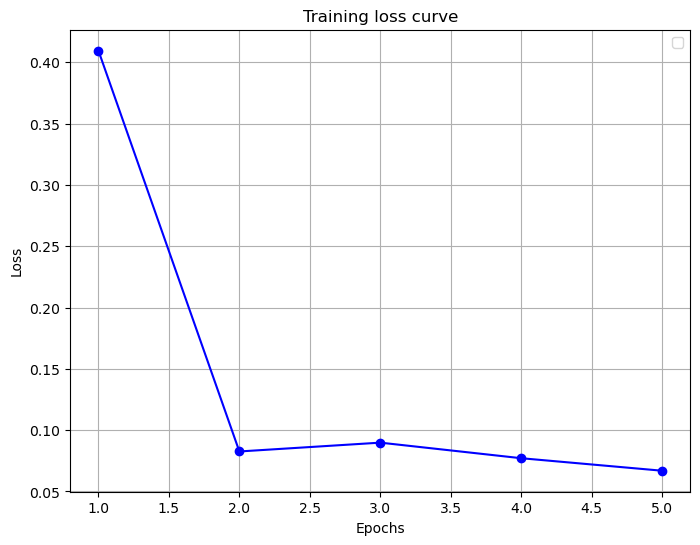

In [18]:
import matplotlib.pyplot as plt

# Data points
x = [1, 2, 3, 4, 5]
y = [0.4094, 0.0826, 0.0898, 0.0771, 0.0669]

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b')
plt.title("Training loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Saving the graph
plt.savefig("graph_plot.png")
plt.show()
